In [1]:
import spacy
from spacy import displacy
from spacy.util import filter_spans
import re
from bs4 import BeautifulSoup
import collections
import requests
import pandas as pd
import pickle
import glob
nlp = spacy.load('en_core_web_trf')
#snt = nlp.create_pipe('sentencizer')

from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from tqdm import tqdm
from spacy.lang.en import English
%matplotlib inline

In [2]:
# Read files
html_list = glob.glob('../../data/raw/POWO/*')

In [3]:
html_list[9]

'../../data/raw/POWO/Garnotia exaristata - Gould.html'

In [12]:
triples = []


def extract_child(soup_object):
    child = soup_object.find_next_sibling()
    return (soup_object.text, 'has', child.text)

def extract_from_sent(text, part):
    doc = nlp(text)
    nouns = [token for token in doc if token.pos_ == 'NOUN']
    for noun in nouns:
        triples.append((part, 'has', noun.text))
        for child in noun.children:
            if child.dep_ == 'amod' and child.pos_ == 'ADJ':
                triples.append((noun.text, 'be', child.text))

for html in tqdm(html_list[0:1]):
    # Open HTML file
    with open(html) as f:
        soup = BeautifulSoup(f, 'html.parser')
        # Extract title
        species = html.lstrip('../data/raw/POWO/').split(' - ')[0]
        # Get Parts
        items = [item for item in soup.select("span.description-type-list-item") if not item.find_previous_sibling()]
        
        for item in items:
            triples.append((species, 'have', item.text))
            if item.find_next_sibling():
                triples.append((item.text, 'have', item.find_next_sibling().text))
                for child in item.find_next_siblings()[:-1]:
                    triples.append(extract_child(child))

                
                if len(item.find_next_siblings()) == 1:
                    text = item.find_next_sibling().find_next().text.strip()
                    attribute = item.find_next_sibling().text
                    extract_from_sent(text, attribute)
                elif len(item.find_next_siblings()) > 1:
                    text = child.find_next_sibling().find_next().text.strip()
                    attribute = child.text
                    extract_from_sent(text, attribute)
                #    print(child.find_next_sibling().find_next().text.strip())
                
                
                
triples = list(set(triples))

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


In [13]:
triples

[('Flowers', 'has', 'Petals'),
 ('endocarp', 'be', 'granular'),
 ('Reproductive morphology', 'has', 'lines'),
 ('Reproductive morphology', 'has', 'latter'),
 ('Reproductive morphology', 'has', 'bracts'),
 ('Gynoecium', 'has', 'filiform'),
 ('mouth', 'be', 'crateriform'),
 ('Reproductive morphology', 'has', 'endocarp'),
 ('Reproductive morphology', 'has', 'Inflorescences'),
 ('Androecium', 'has', 'calyx'),
 ('Reproductive morphology', 'has', 'Seeds'),
 ('Leaves', 'be', 'entire'),
 ('flowers', 'be', 'arranged'),
 ('Reproductive morphology', 'has', 'branches'),
 ('Morphology', 'have', 'Leaves'),
 ('bracts', 'be', 'sterile'),
 ('Inflorescences', 'has', 'Bracts'),
 ('Leaves', 'has', 'hairs'),
 ('endocarp', 'be', 'smooth'),
 ('Androecium', 'has', 'filaments'),
 ('raceme', 'be', 'lax'),
 ('endocarp', 'be', 'non'),
 ('tube', 'be', 'gibbous'),
 ('Inflorescence', 'be', 'flowered'),
 ('style', 'be', 'basal'),
 ('endocarp', 'be', '-'),
 ('Gynoecium', 'has', 'Pistil'),
 ('Leaves', 'has', 'strigose'

In [14]:
#knowledge_list_flat = [RDF for RDF_list in nodes for RDF in RDF_list]

source = [source[0].lower().strip() for source in triples]
relation = [source[1].lower().strip() for source in triples]
target = [source[2].lower().strip() for source in triples]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

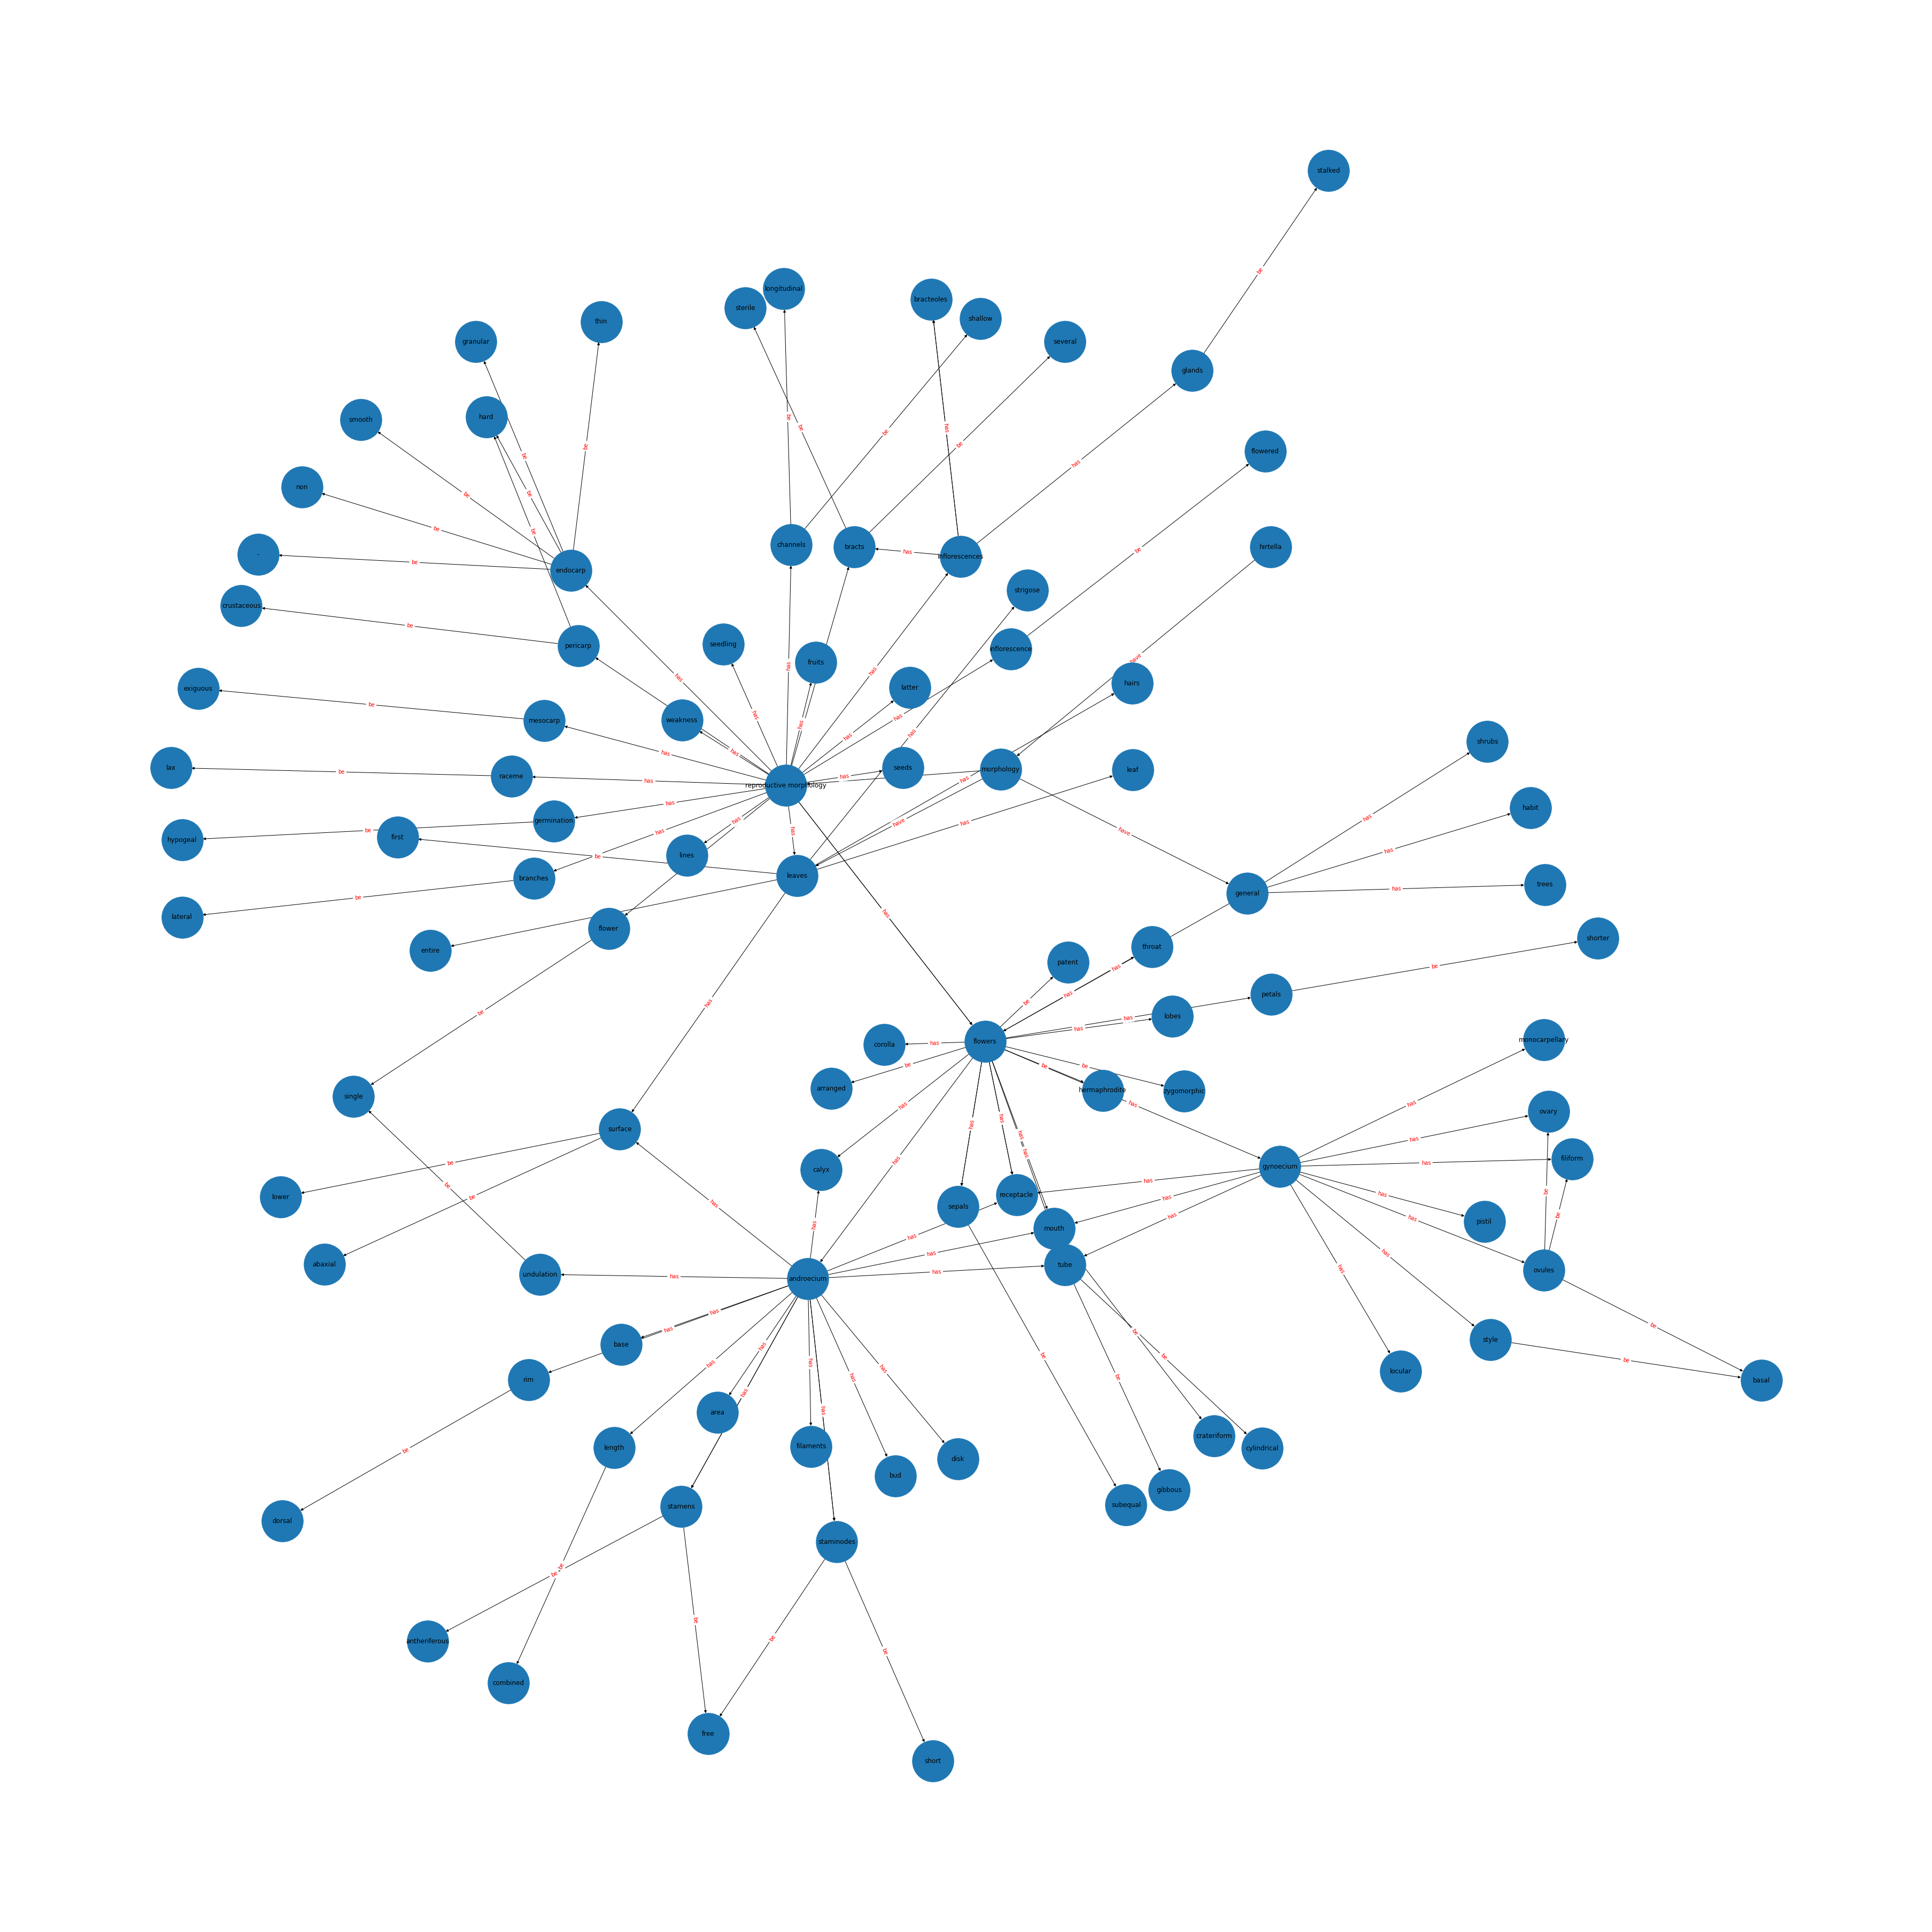

In [15]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(50, 50))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G, k = 1)
nx.draw(G, with_labels=True, node_size=6000, pos=graphviz_layout(G))
nx.draw_networkx_edge_labels(G, pos=graphviz_layout(G), edge_labels=labels,
                                 font_color='red')
plt.show()
#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [68]:
doc = nlp('The claws are sharp.')
svg = displacy.render(doc, style="dep", jupyter=False)

with open('PoS_example2.svg', 'w') as f:
    f.write(svg)

In [39]:
triples = [('Brown bear', 'have', 'fur'),
           ('fur', 'be', 'brown'),
           ('Brown bear', 'have', 'claw'),
           ('claw', 'be', 'sharp')]

In [40]:
source = [source[0].lower().strip() for source in triples]
relation = [source[1].lower().strip() for source in triples]
target = [source[2].lower().strip() for source in triples]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

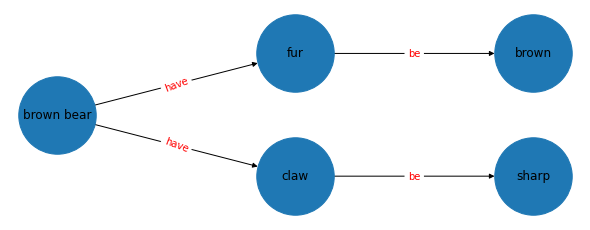

In [69]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8, 3))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G,)

pos['brown bear'] = [0,-0.5]
pos['fur']        = [1, 0]
pos['brown']      = [2, 0]
pos['claw']       = [1, -1]
pos['sharp']      = [2, -1]
nx.draw(G, with_labels=True, node_size=6000, pos=pos)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels,
                                 font_color='red')
plt.margins(y=0.3)
#plt.show()
plt.savefig('kn_example.pdf', format='pdf', dpi=1200, bbox_inches='tight')